In [1]:
import numpy as np
import scipy.stats as st
import math
import sympy as smp
import random as rd
import matplotlib.pyplot as plt

In [2]:
class def_episode:
    def __init__(self, evnts, edge_set):#, lastevnt, pred, succ):
        self.freq = 0
        self.evnts = evnts.copy()
        self.edges = edge_set.copy()
#         self.lastevnt = lastevnt
#         self.pred = pred.copy()
#         self.succ = succ.copy()

class def_NFA:
    def __init__(self):
        self.s = set()
        self.S = list([self.s])
        self.F = -1
        self.D = {}

class def_DFA:
    def __init__(self):
        self.s = {0}
        self.S = list([self.s])
        self.F = list()
        self.D = {}

In [3]:
def Construct_NFA(alpha):
    alpha_size = len(alpha.evnts)
    pi = {}
    for e in alpha.evnts:
        pi[e] = set()
    for (e1,e2) in alpha.edges:
        pi[e2].add(e1)
    NFA = def_NFA()
    n_states = 1
    for Q in NFA.S:
        NFA.D[str(Q)] = {}
        if len(Q) != alpha_size:
            for ev in alpha.evnts-Q:
                if not (alpha.evnts-Q).intersection(pi[ev]):
                    Q_new = Q.copy()
                    Q_new.add(ev)
                    if Q_new in NFA.S:
                        NFA.D[str(Q)][ev] = {NFA.S.index(Q_new)}
                    else:
                        NFA.S.append(Q_new)
                        NFA.D[str(Q)][ev] = {len(NFA.S)-1}
#                     NFA.D[str(Q)][ev] = [Q_new]
#                     if Q_new not in NFA.S:
#                         NFA.S.append(Q_new)
            NFA.D[str(Q)]['def'] = {NFA.S.index(Q)}
        else:
            NFA.D[str(Q)]['def'] = set()
            NFA.F = NFA.S.index(Q)
    for ev in alpha.evnts:
        if not alpha.evnts.intersection(pi[ev]):
            NFA.D[str(NFA.s)][ev].add(0)
    return NFA

In [4]:
def Construct_DFA(NFA):
    DFA = def_DFA()
    for state in DFA.S:
        if (NFA.F in state):
            DFA.F.append(state)
        DFA.D[str(state)] = {}
        W = set({})
        for substate in state:
            Q = str(NFA.S[substate])
            W = W.union(set(NFA.D[Q].keys()))
        for ev in W:
            new_state = set()
            for substate in state:
                Q = str(NFA.S[substate])
                if ev in NFA.D[Q].keys():
                    new_state = new_state.union(NFA.D[Q][ev])
#                     DFA.D[str(state)][ev] = DFA.D[str(state)][ev].union(NFA.D[Q][ev])
                else:
                    new_state = new_state.union(NFA.D[Q]['def'])
#                     DFA.D[str(state)][ev] = DFA.D[str(state)][ev].union(NFA.D[Q]['def'])
            DFA.D[str(state)][ev] = new_state.copy()
            if new_state not in DFA.S:
                        DFA.S.append(new_state)
        keys = list(DFA.D[str(state)].keys())
        for k in range(len(keys)):
            if keys[k] != 'def' and DFA.D[str(state)][keys[k]] == DFA.D[str(state)]['def']:
                del DFA.D[str(state)][keys[k]]
            else:
                k += 1
    return DFA

In [5]:
def GetTransitionMatrix(DFA,prob):
    T0 = list()
    for state in DFA.S:
        T0.append([0]*len(DFA.S))
        for ev in DFA.D[str(state)].keys():
            if ev == 'def':
                continue
            T0[-1][DFA.S.index(DFA.D[str(state)][ev])] += prob[ev]
        T0[-1][DFA.S.index(DFA.D[str(state)]['def'])] = round(1 - sum(T0[-1]),5)
    return(T0)

In [6]:
def GetStats(T0,final_states):
    
    u = smp.symbols('u')
    Dphi = smp.eye(len(T0))
    for final in final_states:
        Dphi[final,final] = u

    Tu = smp.ImmutableSparseMatrix(T0)*smp.ImmutableSparseMatrix(Dphi)
#     smp.pprint(T0)
#     smp.pprint(Dphi)
#     smp.pprint(Tu)

    lamda = smp.symbols('lamda')
    
    Qn = Tu.charpoly(lamda)
#     print(Qn)
#     print(Qn.as_expr())

    dQdu = smp.diff(Qn.as_expr(),u).subs([(u,1),(lamda,1)])
    dQdl = smp.diff(Qn.as_expr(),lamda).subs([(u,1),(lamda,1)])
    d2Qdu2 = smp.diff(smp.diff(Qn.as_expr(),u),u).subs([(u,1),(lamda,1)])
    d2Qdl2 = smp.diff(smp.diff(Qn.as_expr(),lamda),lamda).subs([(u,1),(lamda,1)])
    d2Qdudl = smp.diff(smp.diff(Qn.as_expr(),u),lamda).subs([(u,1),(lamda,1)])

    lambda1 = -dQdu/dQdl
    lambda11 = -(d2Qdu2 + 2*lambda1*d2Qdudl + lambda1**2*d2Qdl2)/dQdl
    # print(lambda1,lambda11)

    MX1 = lambda1
    VX1 = lambda11 + lambda1 - lambda1**2

    return(MX1, VX1)

In [7]:
# Ep_Events = list(['A','B','C'])
# episodes = list([])
# episodes.append(def_episode(set(Ep_Events),set({('A','B'),('A','C'),('B','C')})))
# episodes.append(def_episode(set(Ep_Events),set({('A','B'),('A','C')})))
# episodes.append(def_episode(set(Ep_Events),set({('A','C'),('B','C')})))
# episodes.append(def_episode(set(Ep_Events),set({})))
# probs = np.load('probs_035_evs_3.npy')

Ep_Events = list(['A','B','C','D'])
episodes = list([])
episodes.append(def_episode(set(Ep_Events),set({('A','B'),('A','C'),('A','D'),('B','C'),('B','D'),('C','D')})))
episodes.append(def_episode(set(Ep_Events),set({('A','C'),('A','D'),('B','C'),('B','D'),('C','D')})))
probs = np.load('probs_035_evs_4.npy')


Prob_Ep_Events = {}
for k in range(len(Ep_Events)):
    Prob_Ep_Events[Ep_Events[k]] = probs[k]
    
# print(probs)

In [8]:
episode_id = 0
NFA = Construct_NFA(episodes[episode_id])
DFA = Construct_DFA(NFA)

final_states = set()
for k in range(len(DFA.S)):
    if (NFA.F in DFA.S[k]):
        final_states.add(k)

T0 = GetTransitionMatrix(DFA,Prob_Ep_Events)
# print(len(T0))
# smp.pprint(smp.Matrix(T0))

In [9]:
MX1, VX1 = GetStats(T0,final_states)
# print(MX1, VX1)

In [10]:
runs = 500
T = 1000
freq_list = list([])
states = range(len(T0[0]))
for run in range(runs):
    curr_state = [0]
    ep_freq = 0
    for ti in range(T):
        curr_state = rd.choices(states, T0[curr_state[0]], k=1)
        if curr_state[0] in final_states:
            ep_freq += 1
    freq_list.append(ep_freq)
fmax = max(freq_list)
fmin = min(freq_list)

In [11]:
graph = list([])
for kkk in range(fmin-5,fmax+5):
    graph.append(0)
    for freq in freq_list:
        if freq > kkk:
            graph[-1] += 1/runs

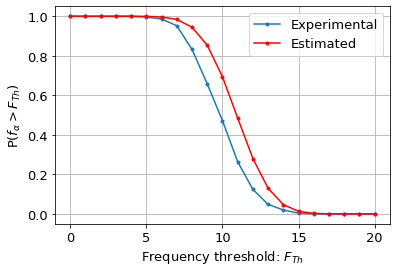

5 16


In [12]:
graph2 = list([])
for kkk in range(fmin-5,fmax+5):
    graph2.append(1-st.norm(loc = T*MX1 , scale = math.sqrt(T*VX1)).cdf(kkk))

plt.rcParams.update({'font.size': 13})
plt.plot(range(fmin-5,fmax+5), graph, '.-')
plt.plot(range(fmin-5,fmax+5), graph2, '.-r')
plt.xlabel('Frequency threshold: $F_{Th}$')
plt.ylabel(r'P$( f_\alpha > F_{Th} )$')
plt.legend(['Experimental','Estimated'])
plt.grid()
plt.show()
print(fmin,fmax)

In [ ]:
# xaxis = range(fmin-5,fmax+5)
# for kkk in range(len(xaxis)):
#     print(str(xaxis[kkk])+'\t'+str(round(graph[kkk],5))+'\t'+str(round(graph2[kkk],3)))

In [116]:
# import numpy as np
# import random as rd
# Ep_Events = list(['A','B','C'])
# Probs = np.zeros((len(Ep_Events)))
# for k in range(len(Ep_Events)):
#     Probs[k] = round(rd.gauss(0.035,sigma=0.001),5)
# print(Probs)
# np.save('probs_035_evs_3',Probs)

In [117]:
# import numpy as np
# import random as rd
# Ep_Events = list(['A','B','C','D'])
# Probs = np.zeros((len(Ep_Events)))
# for k in range(len(Ep_Events)):
#     Probs[k] = round(rd.gauss(0.035,sigma=0.001),5)
# print(Probs)
# np.save('probs_035_evs_4',Probs)

In [118]:
# import numpy as np
# import random as rd
# Ep_Events = list(['A','B','C','D','E'])
# Probs = np.zeros((len(Ep_Events)))
# for k in range(len(Ep_Events)):
#     Probs[k] = round(rd.gauss(0.035,sigma=0.001),5)
# print(Probs)
# np.save('probs_035_evs_5',Probs)

In [119]:
# def GetTransitions(DFA):
#     Mat = list()
#     for state in DFA.S:
#         Mat.append(list())
#         for kkk in range(len(DFA.S)):
#             Mat[-1].append(list())
#         for ev in DFA.D[str(state)].keys():
#             if ev == 'def':
#                 continue
#             Mat[-1][DFA.S.index(DFA.D[str(state)][ev])].append(ev)
#         Mat[-1][DFA.S.index(DFA.D[str(state)]['def'])] = 'def'
#     for rrr in range(len(Mat)):
#         print(DFA.S[rrr], ': ', Mat[rrr])
# GetTransitions(DFA)

In [120]:
# def Print_Automata(NFA,DFA):
#     print('NFA')
#     print('start state: ', NFA.s)
#     print('final state: ', NFA.S[NFA.F])
#     print('\n')
#     for Q in NFA.S:
#         print('Current state: ', Q)
#         print('Transitions:')
#         for ev in NFA.D[str(Q)].keys():
#             print(ev, ' : ', [NFA.S[next_state] for next_state in NFA.D[str(Q)][ev]])
#     #             print(ev,' : ', )
#         print('\n')

#     print('\n \n \nDFA')
#     print('start state: ', [NFA.S[id] for id in list(DFA.s)])
#     print('final states: ')
#     for final in list(DFA.F):
#           print([NFA.S[id] for id in final ])
#     print('\n')

#     for state in DFA.S:
#         print('Current state: ', [NFA.S[Q] for Q in list(state)])
#         print('Transitions:')
#         for ev in DFA.D[str(state)].keys():
#             print(ev, ' : ', [NFA.S[next_state] for next_state in DFA.D[str(state)][ev]])
#         print('\n')
        
# Print_Automata(NFA,DFA)